# **Detección de anomalías**

#### Versión 3

**Librerias**

In [18]:
#pip install rpy2

SyntaxError: invalid syntax (3094688424.py, line 2)

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from math import nan, isnan
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

# Import rpy2 for dataframe conversion
#import rpy2.robjects as ro
#from rpy2.robjects.packages import importr
#from rpy2.robjects import pandas2ri
#from rpy2.robjects.conversion import localconverter
#from rpy2.robjects import globalenv

**Cargando los datos**

In [3]:
master_url_root = "https://raw.githubusercontent.com/numenta/NAB/master/data/"

df_small_noise_url_suffix = "artificialNoAnomaly/art_daily_small_noise.csv"
df_small_noise_url = master_url_root + df_small_noise_url_suffix
df_small_noise = pd.read_csv(
    df_small_noise_url, parse_dates=True, index_col="timestamp"
)

df_daily_jumpsup_url_suffix = "artificialWithAnomaly/art_daily_jumpsup.csv"
df_daily_jumpsup_url = master_url_root + df_daily_jumpsup_url_suffix
df_daily_jumpsup = pd.read_csv(
    df_daily_jumpsup_url, parse_dates=True, index_col="timestamp"
)

**Patron regular**

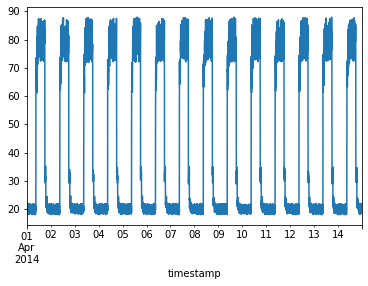

4032

In [4]:
fig, ax = plt.subplots()
df_small_noise.plot(legend=False, ax=ax)
plt.show()
df_small_noise.size

**Patron anormal**

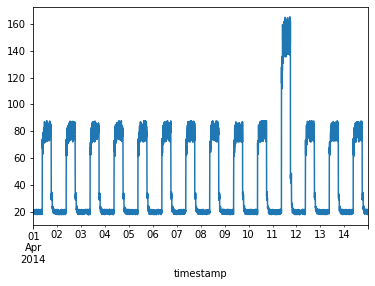

In [5]:
fig, ax = plt.subplots()
df_daily_jumpsup.plot(legend=False, ax=ax)
plt.show()

**Extrayendo una muestra de 2000 observaciones.**

In [6]:
jump = df_daily_jumpsup.iloc[0:2500]
jump.size

2500

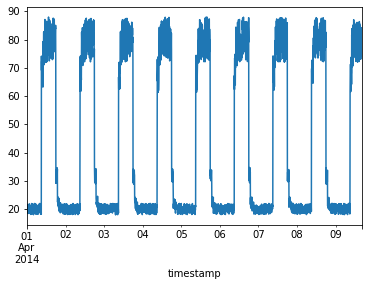

In [7]:
fig, ax = plt.subplots()
jump.plot(legend=False, ax=ax)
plt.show()

# **Análisis**
#### Un estimador de la varianza.



1.   Se construirá un estimador de la varianza a partir de una regresión polinomial local de grado $P$ en una vecindad de radio $R$.
2.   El estimador de la varianza es la varianza estimada del polinomio.



**Selección**

In [8]:
ST = jump

**Análizando al media y volatilidad de los datos**

In [10]:
#ST.to_csv("/content/datos.csv")

In [11]:
colnames=['timestamp','Y','media','radio','Y1','Y109','Y181','Y289'] 
datos = pd.read_csv('datos2.csv',
                    names=colnames,
                    header=1,
                    sep=';')
datos

,timestamp,Y,media,radio,Y1,Y109,Y181,Y289
2,2014-04-01 00:05:00,"20,500833287","20,094374190288","1,10508924688327","19,761251903",NaN,NaN,NaN
3,2014-04-01 00:10:00,"19,9616414445","20,094374190288","1,10508924688327","20,500833287",NaN,NaN,NaN
4,2014-04-01 00:15:00,"21,4902660734","20,094374190288","1,10508924688327","19,9616414445",NaN,NaN,NaN
5,2014-04-01 00:20:00,"20,1877394098","20,094374190288","1,10508924688327","21,4902660734",NaN,NaN,NaN
6,2014-04-01 00:25:00,"19,9231256718","20,094374190288","1,10508924688327","20,1877394098",NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2496,2014-04-09 15:55:00,"83,6180952106","79,2892291169724","4,66709829633724","79,1160883348","20,3112860251","20,4721499222","72,2622832023"
2497,2014-04-09 16:00:00,"82,9164347484","79,2892291169724","4,66709829633724","83,6180952106","18,4550468868","20,8222527614","76,0202775379"
2498,2014-04-09 16:05:00,"74,1656569898","79,2892291169724","4,66709829633724","82,9164347484","19,9078715644","21,3152890284","86,7479173641"
2499,2014-04-09 16:10:00,"74,2860643176","79,2892291169724","4,66709829633724","74,1656569898","19,42490755","21,5106770714","86,816815276"


Quitando las filas con valores faltantes.

In [12]:
datos2 = datos.dropna()
datos2.head()

,timestamp,Y,media,radio,Y1,Y109,Y181,Y289
290,2014-04-02 00:05:00,"20,1630729313","20,3325890728322","1,3383546927693","21,6086167546","77,0638638812","74,1260143836","19,761251903"
291,2014-04-02 00:10:00,"20,7998376509","20,3325890728322","1,3383546927693","20,1630729313","84,51222102","69,1036116436","20,500833287"
292,2014-04-02 00:15:00,"21,3124340371","20,3325890728322","1,3383546927693","20,7998376509","74,8044287246","72,2808540663","19,9616414445"
293,2014-04-02 00:20:00,"21,1661640253","20,3325890728322","1,3383546927693","21,3124340371","84,5211212147","66,9544074866","21,4902660734"
294,2014-04-02 00:25:00,"21,5304224949","20,3325890728322","1,3383546927693","21,1661640253","82,6201685228","73,4850794789","20,1877394098"


**Se hace una partición de 70% para entrenamiento y 30% para validación.**

In [13]:
from sklearn.model_selection import train_test_split

Xtrain, Xtest, Ytrain, Ytest = train_test_split(datos2[['Y1','Y109','Y181','Y289']],
                                                datos2[['media','radio']],
                                                test_size = 0.30,
                                                random_state = 0)

In [14]:
Xtrain.head()

,Y1,Y109,Y181,Y289
1284,"81,0744785146","21,8764661238","21,812735196","80,4205419761"
977,"67,3754355626","21,8627556662","29,8841486663","62,5319617692"
1647,"83,4222314751","18,123011762","20,1580917741","80,2269800876"
2071,"19,2803724363","22,1144755508","84,7468042187","19,4875919623"
588,"18,9253132492","87,4730991023","65,7082949163","18,2826727612"


In [15]:
Ytrain.head()

,media,radio
1284,"79,3676626221598","4,65568428415253"
977,"68,2947234165003","4,95902421549402"
1647,"79,7077768021834","4,57632110557538"
2071,"20,2961389673661","1,2410631252388"
588,"20,3593718607417","1,2917185025835"


**Especificación del modelo**

In [16]:
import tensorflow as tf

ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
entrada =  tf.keras.layers.Dense(units = 4, activation = "relu", input_shape = [4])
oculta1 = tf.keras.layers.Dense(units = 5, activation = "relu")
oculta2 = tf.keras.layers.Dense(units = 3, activation = "relu")
salida = tf.keras.layers.Dense(units = 2, activation = "relu")
modelo = tf.keras.Sequential([entrada, oculta1, oculta2, salida])

In [ ]:
modelo.compile(
    optimizer = tf.keras.optimizers.Adam(0.1),
    loss = 'mean_squared_error'
)

**Entrenamiento**

In [ ]:
type(Xtrain)

In [ ]:
type(Xtrain.values)

In [ ]:
Xtrain.shape

In [ ]:
Xtrain.dtypes

In [ ]:
Xtrain.to_numeric()

In [ ]:
historial = modelo.fit(Xtrain.values, Ytrain.values, epochs = 1000, verbose = False)